## Création d'un modele avec les données propres

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import re

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_error
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from math import sqrt

#import xgboost

In [2]:
data_full = pd.read_csv("logic_immo_trainfull.csv",index_col=0)

In [3]:
data_full.shape

(4298, 23)

In [4]:
columns = data_full.columns.values
columns

array(['id', 'area', 'rooms', 'price', 'district_10', 'district_11',
       'district_12', 'district_13', 'district_14', 'district_15',
       'district_16', 'district_17', 'district_18', 'district_19',
       'district_2', 'district_20', 'district_3', 'district_4',
       'district_5', 'district_6', 'district_7', 'district_8',
       'district_9'], dtype=object)

In [5]:
data_full['price'].describe()

count    4.298000e+03
mean     1.318471e+06
std      1.548441e+06
min      1.100000e+04
25%      4.850000e+05
50%      8.330000e+05
75%      1.605250e+06
max      2.500000e+07
Name: price, dtype: float64

#### Test de suppression des prix trop important pour voir la modification sur la qualité du modele
Ca fonctionne mais pas sur que ca soit une bonne idée , la MAE passe de 330 à 243k , quand on supprime ces biens

In [6]:
data_full.shape

(4298, 23)

In [7]:
#important_prices = data_full.loc[data_full['price'] > 3000000]
#print(len(important_prices))

In [8]:
#print(len(important_prices)/data_full.shape[0]*100)

In [9]:
#data_full = data_full.drop(important_prices.index, axis=0)

In [10]:
data_full.shape

(4298, 23)

In [11]:
data_full['price'].describe()

count    4.298000e+03
mean     1.318471e+06
std      1.548441e+06
min      1.100000e+04
25%      4.850000e+05
50%      8.330000e+05
75%      1.605250e+06
max      2.500000e+07
Name: price, dtype: float64

Log Price
- penser a exp les predictions pour avoir le vrai chiffre

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


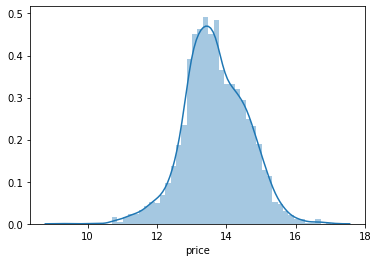

In [12]:
data_full['price'] = np.log(data_full['price'])
sns.distplot(data_full['price'])

#### Split Train / Val

In [13]:
id_column = 'id'
target_column = 'price'
y_train_full_log = data_full[target_column].values
X_train_full = data_full.drop([id_column,target_column], axis=1).values

In [14]:
SEED = 42
np.random.seed(SEED)

In [15]:
X_train, X_val, y_train_log, y_val_log = train_test_split(X_train_full, y_train_full_log, test_size=0.1)

In [16]:
print(f"Train full shape : {data_full.shape}")
print(f"X_train shape : {X_train.shape}")
print(f"X_val shape : {X_val.shape}")
print(f"y_train_log shape : {y_train_log.shape}")
print(f"y_val_log shape : {y_val_log.shape}")

Train full shape : (4298, 23)
X_train shape : (3868, 21)
X_val shape : (430, 21)
y_train_log shape : (3868,)
y_val_log shape : (430,)


#### Scaler
Essai pour trouver le meilleur scaler pour nos données

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [18]:
scalers = [
    MinMaxScaler(),
    MaxAbsScaler(),
    StandardScaler(),
    RobustScaler(),
    Normalizer(),
    QuantileTransformer(),
    PowerTransformer()
]

In [19]:
print("Recherche du meilleur scaler pour nos données")
print("_____________________________________________")
best_score = 0
best_scaler = "Null" 

for scaler in scalers:
    pipe = Pipeline(steps=[('scaler', scaler),('Ridge', Ridge())])
    pipe.fit(X_train,y_train_log)
    print(scaler)
    score = pipe.score(X_val,y_val_log)
    print(score)
    if score > best_score:
        best_score = score
        best_scaler = scaler    
    print("_____________________________________________")
    
print(f"Meilleur scaler {best_scaler} , score : {best_score}")

Recherche du meilleur scaler pour nos données
_____________________________________________
MinMaxScaler(copy=True, feature_range=(0, 1))
0.7482671226814346
_____________________________________________
MaxAbsScaler(copy=True)
0.748152869340488
_____________________________________________
StandardScaler(copy=True, with_mean=True, with_std=True)
0.7500998049467174
_____________________________________________
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
0.7500540686626224
_____________________________________________
Normalizer(copy=True, norm='l2')
0.3160449829073137
_____________________________________________
QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=None,
                    subsample=100000)
0.8229964612112418
_____________________________________________
PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

#### Pipeline

In [20]:
steps = [('scaler', best_scaler) , ('Ridge', Ridge())]
pipeline = Pipeline(steps)

In [21]:
parameters = {'Ridge__solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],'Ridge__alpha': [1e-10,1e-5,1,10,100]}

In [22]:
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)

In [23]:
grid.fit(X_train,y_train_log)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        PowerTransformer(copy=True,
                                                         method='yeo-johnson',
                                                         standardize=True)),
                                       ('Ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'Ridge__alpha': [1e-10, 1e-05, 1, 10, 100],
                         'Ridge__solver': ['auto', 'svd', 'cholesky', '

In [24]:
# Verifie la perfomance sur le val set ? 
# Utilise le scorer du modele si pas précisé dans scoring ? Ridge = R2
grid.score(X_val,y_val_log)

0.876800992347977

In [25]:
grid.best_params_

{'Ridge__alpha': 1, 'Ridge__solver': 'saga'}

In [26]:
y_val_log_predict = grid.best_estimator_.predict(X_val)

In [27]:
print(f" MAE sur val : { round(mean_absolute_error(np.exp(y_val_log),np.exp(y_val_log_predict)),2) } Euros ")

 MAE sur val : 315858.98 Euros 


In [28]:
# Enregistre le modele
pickle.dump(grid, open('realestate_model.pickle', 'wb'))

#### Test prédiction sur nouvel input

[Lien vers l'annonce pour le test](https://www.logic-immo.com/detail-vente-c929c130-fc68-6e83-35a5-8b8f6093f49d.htm)

In [29]:
data_full.head(1)

,id,area,rooms,price,district_10,district_11,district_12,district_13,district_14,district_15,...,district_19,district_2,district_20,district_3,district_4,district_5,district_6,district_7,district_8,district_9
0,8A95B48A-5CB1-C2D0-0C57-563B8A815993,20,2,12.240474,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Pour choisir la ville sans avoir a tout tapper , ou copier/coller ( sera utile dans le code de l'API ) 
- on cherche toutes les colonnes qui commence par " localisation_ " 
- On fait un dictionnaire avec ces colonnes avec toutes les valeurs à zéro
- On passe une des clés a 1 ( la ville ou on veut faire la prédiction )
- Et on ajoute enfin ce dictionnaire au premier dictionnaire comprenant le début du nouvel input dont on veut prédire le prix

In [30]:
list_localisation = []
for column in columns:
    localisation = re.search("^district_",column)
    if(localisation):
        list_localisation.append(column)

In [31]:
list_district = []
for localisation in list_localisation:
    district = localisation.replace("district_","")
    list_district.append(district)
list_district

print(list_district)

pickle.dump(list_district, open('district_values.pickle', 'wb'))

['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']


In [32]:
dict_localisation = { i : [0] for i in list_localisation }

In [33]:
dict_localisation['district_4'] = [1]

In [34]:
dict = {
    'area': [21],
    'rooms': [1],
}

In [35]:
dict.update(dict_localisation)

In [36]:
dict

{'area': [21],
 'rooms': [1],
 'district_10': [0],
 'district_11': [0],
 'district_12': [0],
 'district_13': [0],
 'district_14': [0],
 'district_15': [0],
 'district_16': [0],
 'district_17': [0],
 'district_18': [0],
 'district_19': [0],
 'district_2': [0],
 'district_20': [0],
 'district_3': [0],
 'district_4': [1],
 'district_5': [0],
 'district_6': [0],
 'district_7': [0],
 'district_8': [0],
 'district_9': [0]}

In [37]:
df_pred = pd.DataFrame(dict)
df_pred

,area,rooms,district_10,district_11,district_12,district_13,district_14,district_15,district_16,district_17,...,district_19,district_2,district_20,district_3,district_4,district_5,district_6,district_7,district_8,district_9
0,21,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [38]:
X_new = df_pred.values

In [39]:
X_new

array([[21,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         0,  0,  0,  0,  0]])

### Prediction
Test avec l'input <br>
![photo d'appartement](https://mmf.logic-immo.com/mmf/ads/photo-prop-800x600/c92/a/a50f3829-eb6a-4b79-b16d-44b5cedb5c9b.jpg)

In [40]:
new_pred2 = grid.best_estimator_.predict(X_new)

In [41]:
int(np.exp(new_pred2[0]))

330051

In [42]:
# model = pickle.load(open('realestate_model', 'rb'))